In [51]:
import torch

DATASET_DIR = "/kaggle/input/face-dataset/dataset_new/dataset_new"
TRAIN_DIR = "./datasets/train/images"
TEST_DIR = "./datasets/test/images"
EPOCHS = 20
LR = 0.0001
BATCH_SIZE = 32

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = 512

In [54]:
import os
import shutil
import random
from tqdm.auto import tqdm


def split_data():
    source_dir = DATASET_DIR
    train_dir = TRAIN_DIR
    test_dir = TEST_DIR
    # Check if train_dir and test_dir already exist
    if os.path.exists(train_dir) and os.path.exists(test_dir):
        print("Train and test directories already exist. Skipping splitting process.")
        return

    # creates directory if it doesn't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # List all image files in the source directory
    image_files = os.listdir(source_dir)

    # calculate 80% and 20% split
    train_count = int(len(image_files) * 0.8)
    test_count = len(image_files) - train_count

    # randomly shuffle the list of image files
    random.shuffle(image_files)
    print(
        f"""
    Train images : {train_count}
    Test images : {test_count}
    """
    )

    # copy images to train and test directories
    for i, image_file in tqdm(
        enumerate(image_files), total=len(image_files), colour="CYAN"
    ):
        source_path = os.path.join(source_dir, image_file)
        if i < train_count:
            destination_path = os.path.join(train_dir, image_file)
        else:
            destination_path = os.path.join(test_dir, image_file)
        shutil.copyfile(source_path, destination_path)

    print("Images copied successfully!")


split_data()


    Train images : 8191
    Test images : 2048
    


  0%|          | 0/10239 [00:00<?, ?it/s]

Images copied successfully!


---
# **Utility functions**
---

In [84]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import save_image, make_grid


def denorm(img_tensors):
    STATS = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    return img_tensors * STATS[1][0] + STATS[0][0]


In [85]:
# Function to display images
def show_images(clean_images, noisy_images):
    num_samples = min(4, len(clean_images))  # Number of samples to visualize
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 3, 6))

    for i in range(num_samples):
        # Convert tensors to PIL images
        clean_img_pil = to_pil_image(denorm(clean_images[i]))
        noisy_img_pil = to_pil_image(denorm(noisy_images[i]))

        # Plot clean image
        axes[0, i].imshow(clean_img_pil)
        axes[0, i].set_title("Clean Image")
        axes[0, i].axis("off")

        # Plot noisy image
        axes[1, i].imshow(noisy_img_pil)
        axes[1, i].set_title("Noisy Image")
        axes[1, i].axis("off")

    plt.show()



In [86]:
def save_model_state_dict(state_dict, directory, filename):
    """
    Save the state dictionary of a model to a .pth file.

    Args:
    - state_dict (dict): The state dictionary of the model.
    - directory (str): The directory where the .pth file will be saved.
    - filename (str): The name of the .pth file to save.
    """
    # Ensure that the directory exists
    os.makedirs(directory, exist_ok=True)

    # Construct the full file path
    filepath = os.path.join(directory, filename)

    # Save the state dictionary
    torch.save(state_dict, filepath)


In [87]:
def save_samples(index, generator, latent_tensors, show=True):
    sample_dir = "images"
    os.makedirs(sample_dir, exist_ok=True)

    fake_images = generator(latent_tensors.to(DEVICE))
    fake_fname = f"generated-images-{index:0=4d}.png"
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print("Saving : ", fake_fname)

    if show:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(
            make_grid(denorm(fake_images).cpu().detach(), nrow=8).permute(1, 2, 0)
        )


In [88]:
def save_batch_image(clean_images, noisy_images):
    sample_dir = "images"
    os.makedirs(sample_dir, exist_ok=True)

    clean_fname = "clean-images-0000.png"
    save_image(denorm(clean_images), os.path.join(sample_dir, clean_fname), nrow=8)
    print(f"Saving : `{clean_fname}`")

    noisy_fname = "noisy-images-0000.png"
    save_image(denorm(noisy_images), os.path.join(sample_dir, noisy_fname), nrow=8)
    print(f"Saving : `{noisy_fname}`\n\n")


In [89]:
def get_fixed_latent():
    fixed_latent = None
    for noisy, clean in create_test_dataloader():
        noisy_latent = noisy.to(DEVICE)
        clean_latent = clean.to(DEVICE)
        return noisy_latent, clean_latent

In [90]:
def save_samples(index, generator, latent_tensors, show=True):
    sample_dir = "images"
    os.makedirs(sample_dir, exist_ok=True)

    fake_images = generator(latent_tensors.to(DEVICE))
    fake_fname = f"generated-images-{index:0=4d}.png"
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print("Saving : ", fake_fname)

    if show:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(
            make_grid(denorm(fake_images).cpu().detach(), nrow=8).permute(1, 2, 0)
        )

---
# **Data Loader**
---

In [91]:
import os
import cv2
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader




class ToPILImage(object):
    """Convert a tensor or an ndarray to PIL Image."""

    def __call__(self, pic):
        """
        Args:
            pic (Tensor or ndarray): Image to be converted to PIL Image.
        Returns:
            PIL Image: Converted image.
        """
        if isinstance(pic, torch.Tensor):
            pic = transforms.ToPILImage()(pic)
        return pic


class DenoisingDataset(Dataset):
    def __init__(self, root_dir, noise_std=0.1, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_filenames = [
            filename
            for filename in os.listdir(root_dir)
            if filename.endswith(".jpg") or filename.endswith(".png")
        ]
        self.noise_std = noise_std

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        clean_image_name = os.path.join(self.root_dir, self.image_filenames[idx])
        clean_image = Image.open(clean_image_name).convert("RGB")

        # Apply ToTensor transformation if necessary
        if not isinstance(clean_image, torch.Tensor):
            clean_image = transforms.ToTensor()(clean_image)

        # Add Gaussian noise to the clean image
        noisy_image = clean_image + torch.randn_like(clean_image) * self.noise_std
        noisy_image = torch.clamp(
            noisy_image, 0, 1
        )  # Ensure pixel values are in [0, 1]

        if self.transform:
            clean_image = self.transform(clean_image)
            noisy_image = self.transform(noisy_image)

        return noisy_image, clean_image


class BlurryDataset(Dataset):
    def __init__(self, root_dir, blur_radius=5, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_filenames = [
            filename
            for filename in os.listdir(root_dir)
            if filename.endswith(".jpg") or filename.endswith(".png")
        ]
        self.blur_radius = blur_radius

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        clean_image_name = os.path.join(self.root_dir, self.image_filenames[idx])
        clean_image = Image.open(clean_image_name).convert("RGB")

        # Apply blur using cv2.blur
        image_np = transforms.ToPILImage()(clean_image)  # Convert to PIL image
        image_np = cv2.cvtColor(
            np.array(image_np), cv2.COLOR_RGB2BGR
        )  # Convert to numpy array in BGR format
        blurry_image_np = cv2.blur(
            image_np, (self.blur_radius, self.blur_radius)
        )  # Apply blur
        blurry_image = transforms.ToTensor()(blurry_image_np)  # Convert back to tensor

        if self.transform:
            clean_image = self.transform(clean_image)
            blurry_image = self.transform(blurry_image)

        return blurry_image, clean_image


data_transform = transforms.Compose(
    [
        ToPILImage(),  # Convert back to PIL Image
        transforms.Resize((512, 512)),  # Resize images if necessary
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)


def create_train_dataloader():
    #####################
    # Train Dataloader
    #####################
    split_data()

    train_dataset = DenoisingDataset(
        root_dir="./datasets/train/images/", noise_std=0.6, transform=data_transform
    )
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    return train_loader


def create_test_dataloader():
    #####################
    # Test Dataloader
    #####################
    split_data()

    test_dataset = DenoisingDataset(
        root_dir="./datasets/test/images/", noise_std=0.6, transform=data_transform
    )
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

    return test_loader


# if __name__ == "__main__":
#     test_loader = create_test_dataloader()
#     print(
#         f"""
#     length of test loader : {len(test_loader)}
#     """
#     )

#     for noisy, clean in test_loader:
#         print(f"Shape of noisy : {noisy.shape}")
#         print(f"Shape of clean : {clean.shape}")
#         break

---
# **Model Architecture of `pix2pix` GAN**
---

---
## **Discriminator Architecture**
---

In [39]:
import torch
import torch.nn as nn


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels * 2,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            ),
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.model(x)
        return x


def test():
    from torchinfo import summary
    x = torch.randn((32, 3, 512, 512))
    y = torch.randn((32, 3, 512, 512))
    model_d = Discriminator(in_channels=3)
    
#     summary(model_d, input_data=(x,y))
    
    preds = model_d(x, y)
    print(model_d)
    print(preds.shape)


# test()

In [40]:
from torchinfo import summary

x = torch.randn((32, 3, 512, 512))
y = torch.randn((32, 3, 512, 512))
model_d = Discriminator(in_channels=3)
summary(model_d, input_data=(x,y))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [32, 1, 62, 62]           --
├─Sequential: 1-1                        [32, 64, 256, 256]        --
│    └─Conv2d: 2-1                       [32, 64, 256, 256]        6,208
│    └─LeakyReLU: 2-2                    [32, 64, 256, 256]        --
├─Sequential: 1-2                        [32, 1, 62, 62]           --
│    └─CNNBlock: 2-3                     [32, 128, 128, 128]       --
│    │    └─Sequential: 3-1              [32, 128, 128, 128]       131,328
│    └─CNNBlock: 2-4                     [32, 256, 64, 64]         --
│    │    └─Sequential: 3-2              [32, 256, 64, 64]         524,800
│    └─CNNBlock: 2-5                     [32, 512, 63, 63]         --
│    │    └─Sequential: 3-3              [32, 512, 63, 63]         2,098,176
│    └─Conv2d: 2-6                       [32, 1, 62, 62]           8,193
Total params: 2,768,705
Trainable params: 2,768,705
Non-traina

In [41]:
# https://github.com/akanametov/pix2pix/blob/main/gan/generator.py

import torch
from torch import nn
from torch.nn import functional as F


class EncoderBlock(nn.Module):
    """Encoder block"""
    def __init__(self, inplanes, outplanes, kernel_size=4, stride=2, padding=1, norm=True):
        super().__init__()
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        self.conv = nn.Conv2d(inplanes, outplanes, kernel_size, stride, padding)
        
        self.bn=None
        if norm:
            self.bn = nn.BatchNorm2d(outplanes)
        
    def forward(self, x):
        fx = self.lrelu(x)
        fx = self.conv(fx)
        
        if self.bn is not None:
            fx = self.bn(fx)
            
        return fx

    
class DecoderBlock(nn.Module):
    """Decoder block"""
    def __init__(self, inplanes, outplanes, kernel_size=4, stride=2, padding=1, dropout=False):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.deconv = nn.ConvTranspose2d(inplanes, outplanes, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(outplanes)       
        
        self.dropout=None
        if dropout:
            self.dropout = nn.Dropout2d(p=0.5, inplace=True)
            
    def forward(self, x):
        fx = self.relu(x)
        fx = self.deconv(fx)
        fx = self.bn(fx)

        if self.dropout is not None:
            fx = self.dropout(fx)
            
        return fx

    
class Generator(nn.Module):
    """Encoder-Decoder model"""
    def __iGeneratornit__(self,):
        super().__init__()
        
        self.encoder1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.encoder2 = EncoderBlock(64, 128)
        self.encoder3 = EncoderBlock(128, 256)
        self.encoder4 = EncoderBlock(256, 512)
        self.encoder5 = EncoderBlock(512, 512)
        self.encoder6 = EncoderBlock(512, 512)
        self.encoder7 = EncoderBlock(512, 512)
        self.encoder8 = EncoderBlock(512, 512, norm=False)
        
        self.decoder8 = DecoderBlock(512, 512, dropout=True)
        self.decoder7 = DecoderBlock(512, 512, dropout=True)
        self.decoder6 = DecoderBlock(512, 512, dropout=True)
        self.decoder5 = DecoderBlock(512, 512)
        self.decoder4 = DecoderBlock(512, 256)
        self.decoder3 = DecoderBlock(256, 128)
        self.decoder2 = DecoderBlock(128, 64)
        self.decoder1 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)
        
    def forward(self, x):
        # encoder forward
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        e5 = self.encoder5(e4)
        e6 = self.encoder6(e5)
        e7 = self.encoder7(e6)
        e8 = self.encoder8(e7)
        # decoder forward
        d8 = self.decoder8(e8)
        d7 = self.decoder7(d8)
        d6 = self.decoder6(d7)
        d5 = self.decoder5(d6)
        d4 = self.decoder4(d5)
        d3 = self.decoder3(d4)
        d2 = F.relu(self.decoder2(d3))
        d1 = self.decoder1(d2)
        
        return torch.tanh(d1)
    
    
class UnetGenerator(nn.Module):
    """Unet-like Encoder-Decoder model"""
    def __init__(self,):
        super().__init__()
        
        self.encoder1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.encoder2 = EncoderBlock(64, 128)
        self.encoder3 = EncoderBlock(128, 256)
        self.encoder4 = EncoderBlock(256, 512)
        self.encoder5 = EncoderBlock(512, 512)
        self.encoder6 = EncoderBlock(512, 512)
        self.encoder7 = EncoderBlock(512, 512)
        self.encoder8 = EncoderBlock(512, 512, norm=False)
        
        self.decoder8 = DecoderBlock(512, 512, dropout=True)
        self.decoder7 = DecoderBlock(2*512, 512, dropout=True)
        self.decoder6 = DecoderBlock(2*512, 512, dropout=True)
        self.decoder5 = DecoderBlock(2*512, 512)
        self.decoder4 = DecoderBlock(2*512, 256)
        self.decoder3 = DecoderBlock(2*256, 128)
        self.decoder2 = DecoderBlock(2*128, 64)
        self.decoder1 = nn.ConvTranspose2d(2*64, 3, kernel_size=4, stride=2, padding=1)
        
    def forward(self, x):
        # encoder forward
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        e5 = self.encoder5(e4)
        e6 = self.encoder6(e5)
        e7 = self.encoder7(e6)
        e8 = self.encoder8(e7)
        # decoder forward + skip connections
        d8 = self.decoder8(e8)
        d8 = torch.cat([d8, e7], dim=1)
        d7 = self.decoder7(d8)
        d7 = torch.cat([d7, e6], dim=1)
        d6 = self.decoder6(d7)
        d6 = torch.cat([d6, e5], dim=1)
        d5 = self.decoder5(d6)
        d5 = torch.cat([d5, e4], dim=1)
        d4 = self.decoder4(d5)
        d4 = torch.cat([d4, e3], dim=1)
        d3 = self.decoder3(d4)
        d3 = torch.cat([d3, e2], dim=1)
        d2 = F.relu(self.decoder2(d3))
        d2 = torch.cat([d2, e1], dim=1)
        d1 = self.decoder1(d2)
        
        return torch.tanh(d1)
    
    
def test():
    from torchinfo import summary
    x = torch.randn((32, 3, 1024, 1024))
    model_g = UnetGenerator().to(torch.device('cuda'))
#     summary(model_g, input_data=x)
    recon = model_g(x)
    print(model_g)
    print(recon.shape)


# test()


In [42]:
from torchinfo import summary
model_g = UnetGenerator().to(DEVICE)

x = torch.randn((32, 3, 512, 512)).to(DEVICE)

summary(model_g, input_data=x)

Layer (type:depth-idx)                   Output Shape              Param #
UnetGenerator                            [32, 3, 512, 512]         --
├─Conv2d: 1-1                            [32, 64, 256, 256]        3,136
├─EncoderBlock: 1-2                      [32, 128, 128, 128]       --
│    └─LeakyReLU: 2-1                    [32, 64, 256, 256]        --
│    └─Conv2d: 2-2                       [32, 128, 128, 128]       131,200
│    └─BatchNorm2d: 2-3                  [32, 128, 128, 128]       256
├─EncoderBlock: 1-3                      [32, 256, 64, 64]         --
│    └─LeakyReLU: 2-4                    [32, 128, 128, 128]       --
│    └─Conv2d: 2-5                       [32, 256, 64, 64]         524,544
│    └─BatchNorm2d: 2-6                  [32, 256, 64, 64]         512
├─EncoderBlock: 1-4                      [32, 512, 32, 32]         --
│    └─LeakyReLU: 2-7                    [32, 256, 64, 64]         --
│    └─Conv2d: 2-8                       [32, 512, 32, 32]         2,0

---
# _**`Criterion.py`**_
---

In [43]:
import torch
from torch import nn


class GeneratorLoss(nn.Module):
    def __init__(self, alpha=100):
        super().__init__()
        self.alpha = alpha
        self.bce = nn.BCEWithLogitsLoss()
        self.l1 = nn.L1Loss()

    def forward(self, fake, real, fake_pred):
        fake_target = torch.ones_like(fake_pred)
        loss = self.bce(fake_pred, fake_target) + self.alpha * self.l1(fake, real)
        return loss


class DiscriminatorLoss(nn.Module):
    def __init__(
        self,
    ):
        super().__init__()
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, fake_pred, real_pred):
        fake_target = torch.zeros_like(fake_pred)
        real_target = torch.ones_like(real_pred)
        fake_loss = self.loss_fn(fake_pred, fake_target)
        real_loss = self.loss_fn(real_pred, real_target)
        loss = (fake_loss + real_loss) / 2
        return loss

---
# **Train Discriminator**
---

In [63]:


def train_discriminator(
    d_optimizer,
    clean_images,
    noisy_images,
    generator,
    discriminator,
    d_criterion,
):
    # clear discriminator gradients
    d_optimizer.zero_grad()

    # Generate fake images by sending noisy_image
    fake = generator(noisy_images).detach()  # denoised

    # forward pass images through discriminator
    fake_preds = discriminator(fake, noisy_images)  # should classify as fake

    # Forward pass clean images through the discriminator
    real_preds = discriminator(clean_images, noisy_images)  # should classify as real

    # Compute discriminator loss
    d_loss = d_criterion(fake_preds, real_preds)

    real_preds_score = torch.mean(real_preds).item()
    fake_preds_score = torch.mean(fake_preds).item()

    # update discriminator weights
    d_loss.backward()  # compute the gradients of the loss with respect to the every single weight of discriminator
    d_optimizer.step()  # update the weights and biases of the discriminator only
    return d_loss.item(), real_preds_score, fake_preds_score



---
# **Train Discriminator**
---

In [64]:
import torch
from tqdm.auto import tqdm

def train_generator(
    g_optimizer,
    clean_images,
    noisy_images,
    generator,
    discriminator,
    g_criterion,
):
    # clear the gradient
    g_optimizer.zero_grad()

    # Forward pass noisy images through the generator
    fake_images = generator(noisy_images)

    # Forward pass denoised images through the discriminator
    fake_preds = discriminator(fake_images, clean_images)

    # Compute generator loss
    g_loss = g_criterion(fake_images, clean_images, fake_preds)

    # update generator weights
    g_loss.backward()  #
    g_optimizer.step()  # update the weights and bias of the generator

    return g_loss.item()


---
# training function
---

In [65]:
def fit(
    train_dl,
    epochs,
    lr,
    g_criterion,
    d_criterion,
    fixed_latent,
    generator_state_dict_file=None,
    discriminator_state_dict_file=None,
    start_idx=1,
    device: torch.device = DEVICE,
):

    torch.cuda.empty_cache()
    save_dir = "models"

    # initializing generator
    generator = UnetGenerator().to(device)
    # initializing discriminator
    discriminator = Discriminator().to(device)

    print(f"generator's device: {next(generator.parameters()).device}")
    print(f"discriminator's device: {next(discriminator.parameters()).device}]\n\n")

    # loading state_dict of the generator and discriminator
    # path to file is passed as argument
    if generator_state_dict_file:
        generator_state_dict = torch.load(generator_state_dict_file)
        generator.load_state_dict(generator_state_dict)

    if discriminator_state_dict_file:
        discriminator_state_dict = torch.load(discriminator_state_dict_file)
        discriminator.load_state_dict(discriminator_state_dict)

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    # Initialize variables to keep track of best losses
    best_discriminator_loss = float("inf")
    best_generator_loss = float("inf")

    # Losses & scores
    d_loss = 0.0
    g_loss = 0.0
    real_score = 0.0
    fake_score = 0.0

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    for epoch in range(epochs):
        for noisy_images, clean_images in tqdm(
            train_dl, colour="CYAN", desc=f"Epoch - [{epoch+1}/{epochs}] "
        ):

            noisy_images = noisy_images.to(DEVICE)
            clean_images = clean_images.to(DEVICE)

            ######################
            #   Train Generator  #
            ######################

            d_loss, real_score, fake_score = train_discriminator(
                opt_d,
                clean_images,
                noisy_images,
                generator,
                discriminator,
                d_criterion,
            )
            ########################
            # Train Discriminator  #
            ########################
            g_loss = train_generator(
                opt_g, clean_images, noisy_images, generator, discriminator, g_criterion
            )

        # Record losses & scores
        losses_g.append(g_loss)
        losses_d.append(d_loss)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print(
            f"  [+] Epoch [{epoch+1}/{epochs}], loss_g: {g_loss:.4e}, loss_d: {d_loss:.4e}, real_score: {real_score:.4e}, fake_score: {fake_score:.4e}\n\n"
        )

        # Save the state dictionaries after every 10th epoch
        if (epoch + 1) % 10 == 0:
            save_model_state_dict(
                discriminator.state_dict(),
                save_dir,
                f"discriminator_epoch_{epoch+1}.pth",
            )
            save_model_state_dict(
                generator.state_dict(), save_dir, f"generator_epoch_{epoch+1}.pth"
            )

        # Check if the current epoch achieves the best discriminator loss
        if d_loss < best_discriminator_loss:
            best_discriminator_loss = d_loss
            save_model_state_dict(
                discriminator.state_dict(), save_dir, "best_discriminator.pth"
            )

        # Check if the current epoch achieves the best generator loss
        if g_loss < best_generator_loss:
            best_generator_loss = g_loss
            save_model_state_dict(
                generator.state_dict(), save_dir, "best_generator.pth"
            )
        # Save generated images
        save_samples(epoch + start_idx, generator, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores




In [66]:
torch.cuda.empty_cache()
train_dl = create_train_dataloader()
noisy_latent, clean_latent = get_fixed_latent()

g_criterion = GeneratorLoss(alpha=100)
d_criterion = DiscriminatorLoss()

save_batch_image(clean_latent, noisy_latent)


Train and test directories already exist. Skipping splitting process.
Train and test directories already exist. Skipping splitting process.
Saving : `clean-images-0000.png`
Saving : `noisy-images-0000.png`




In [67]:
g_model = UnetGenerator().to(DEVICE)


Saving :  generated-images-0001.png


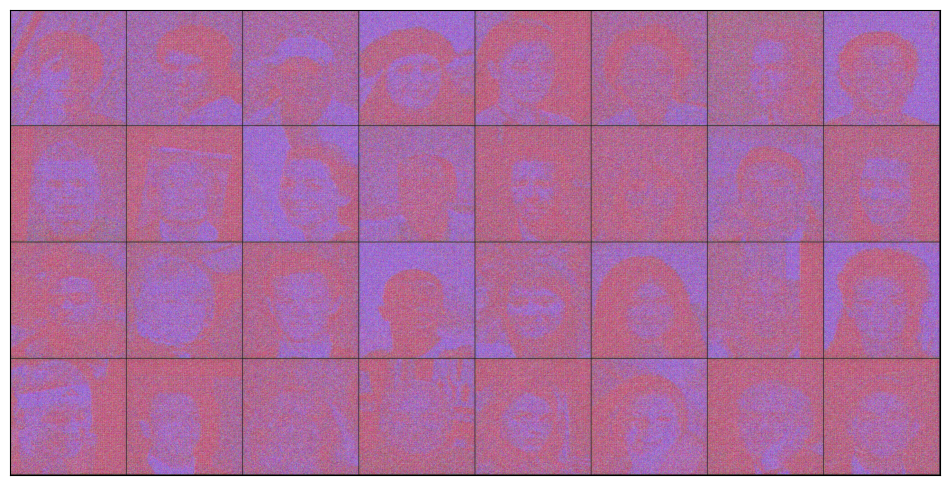

In [68]:
save_samples(1, g_model, noisy_latent)

In [70]:
history = []
history += fit(
    train_dl=train_dl,
    epochs=40,
    lr=LR,
    g_criterion=g_criterion,
    d_criterion=d_criterion,
    start_idx=2,
    fixed_latent=noisy_latent,
)
print(history)

generator's device: cuda:0
discriminator's device: cuda:0]




Epoch - [1/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [1/40], loss_g: 1.4376e+01, loss_d: 6.4185e-01, real_score: 4.9178e-01, fake_score: 1.5813e-01


Saving :  generated-images-0002.png


Epoch - [2/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [2/40], loss_g: 1.1307e+01, loss_d: 5.8234e-01, real_score: 2.3851e-01, fake_score: -3.1761e-01


Saving :  generated-images-0003.png


Epoch - [3/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [3/40], loss_g: 1.0090e+01, loss_d: 4.0510e-01, real_score: 6.2226e-01, fake_score: -9.8243e-01


Saving :  generated-images-0004.png


Epoch - [4/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [4/40], loss_g: 1.0095e+01, loss_d: 9.5960e-02, real_score: 2.5130e+00, fake_score: -2.5641e+00


Saving :  generated-images-0005.png


Epoch - [5/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [5/40], loss_g: 9.8774e+00, loss_d: 4.6117e-02, real_score: 3.8426e+00, fake_score: -2.9637e+00


Saving :  generated-images-0006.png


Epoch - [6/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [6/40], loss_g: 9.4353e+00, loss_d: 6.8408e-01, real_score: 9.4266e-02, fake_score: 1.2298e-03


Saving :  generated-images-0007.png


Epoch - [7/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [7/40], loss_g: 8.7635e+00, loss_d: 3.8226e-01, real_score: 2.5580e+00, fake_score: -3.5237e-01


Saving :  generated-images-0008.png


Epoch - [8/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [8/40], loss_g: 9.8259e+00, loss_d: 5.5713e-02, real_score: 3.4050e+00, fake_score: -3.6328e+00


Saving :  generated-images-0009.png


Epoch - [9/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [9/40], loss_g: 8.4471e+00, loss_d: 4.6490e-02, real_score: 3.0979e+00, fake_score: -4.2841e+00


Saving :  generated-images-0010.png


Epoch - [10/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [10/40], loss_g: 8.9488e+00, loss_d: 9.4661e-03, real_score: 5.0880e+00, fake_score: -5.4831e+00


Saving :  generated-images-0011.png


Epoch - [11/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [11/40], loss_g: 9.4596e+00, loss_d: 8.7029e-03, real_score: 5.2173e+00, fake_score: -5.2567e+00


Saving :  generated-images-0012.png


Epoch - [12/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [12/40], loss_g: 8.3805e+00, loss_d: 3.0671e-03, real_score: 6.2330e+00, fake_score: -7.0407e+00


Saving :  generated-images-0013.png


Epoch - [13/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [13/40], loss_g: 8.1340e+00, loss_d: 1.0118e-02, real_score: 5.9786e+00, fake_score: -4.5800e+00


Saving :  generated-images-0014.png


Epoch - [14/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [14/40], loss_g: 7.8520e+00, loss_d: 3.4519e-01, real_score: 6.7982e-01, fake_score: -2.5664e+00


Saving :  generated-images-0015.png


Epoch - [15/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [15/40], loss_g: 8.1857e+00, loss_d: 1.8719e-02, real_score: 5.1968e+00, fake_score: -4.0074e+00


Saving :  generated-images-0016.png


Epoch - [16/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [16/40], loss_g: 8.3111e+00, loss_d: 1.4664e-02, real_score: 4.5899e+00, fake_score: -4.9079e+00


Saving :  generated-images-0017.png


Epoch - [17/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [17/40], loss_g: 7.9835e+00, loss_d: 8.9700e-03, real_score: 5.4707e+00, fake_score: -5.5368e+00


Saving :  generated-images-0018.png


Epoch - [18/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [18/40], loss_g: 7.9925e+00, loss_d: 2.3449e-03, real_score: 6.3312e+00, fake_score: -7.2214e+00


Saving :  generated-images-0019.png


Epoch - [19/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [19/40], loss_g: 8.2346e+00, loss_d: 2.7214e-03, real_score: 6.7273e+00, fake_score: -6.4694e+00


Saving :  generated-images-0020.png


Epoch - [20/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [20/40], loss_g: 8.1580e+00, loss_d: 3.6826e-03, real_score: 6.2708e+00, fake_score: -5.9643e+00


Saving :  generated-images-0021.png


Epoch - [21/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [21/40], loss_g: 7.5956e+00, loss_d: 3.2466e-03, real_score: 6.0606e+00, fake_score: -6.3439e+00


Saving :  generated-images-0022.png


Epoch - [22/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [22/40], loss_g: 1.5058e+01, loss_d: 5.2033e+00, real_score: 2.7062e+00, fake_score: 5.7068e-01


Saving :  generated-images-0023.png


Epoch - [23/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [23/40], loss_g: 8.9358e+00, loss_d: 6.4442e-01, real_score: 2.5730e-01, fake_score: -1.5616e-01


Saving :  generated-images-0024.png


Epoch - [24/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [24/40], loss_g: 8.9888e+00, loss_d: 2.0651e-01, real_score: 2.3811e+00, fake_score: -1.4464e+00


Saving :  generated-images-0025.png


Epoch - [25/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [25/40], loss_g: 8.6467e+00, loss_d: 1.9266e-02, real_score: 4.4208e+00, fake_score: -4.6350e+00


Saving :  generated-images-0026.png


Epoch - [26/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [26/40], loss_g: 8.5394e+00, loss_d: 2.3727e-02, real_score: 4.6779e+00, fake_score: -4.6156e+00


Saving :  generated-images-0027.png


Epoch - [27/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [27/40], loss_g: 8.0563e+00, loss_d: 1.1913e-02, real_score: 5.7010e+00, fake_score: -5.2602e+00


Saving :  generated-images-0028.png


Epoch - [28/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [28/40], loss_g: 8.1308e+00, loss_d: 2.7443e-02, real_score: 4.9531e+00, fake_score: -4.4087e+00


Saving :  generated-images-0029.png


Epoch - [29/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [29/40], loss_g: 7.9288e+00, loss_d: 4.0775e-03, real_score: 5.6782e+00, fake_score: -6.8924e+00


Saving :  generated-images-0030.png


Epoch - [30/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [30/40], loss_g: 8.2164e+00, loss_d: 2.6400e-03, real_score: 6.7304e+00, fake_score: -6.1602e+00


Saving :  generated-images-0031.png


Epoch - [31/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [31/40], loss_g: 8.5276e+00, loss_d: 2.0638e-03, real_score: 6.2808e+00, fake_score: -7.5950e+00


Saving :  generated-images-0032.png


Epoch - [32/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [32/40], loss_g: 8.3490e+00, loss_d: 4.4442e-03, real_score: 6.1049e+00, fake_score: -6.6699e+00


Saving :  generated-images-0033.png


Epoch - [33/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [33/40], loss_g: 7.4230e+00, loss_d: 2.4607e-03, real_score: 6.6741e+00, fake_score: -6.6359e+00


Saving :  generated-images-0034.png


Epoch - [34/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [34/40], loss_g: 8.1701e+00, loss_d: 8.6034e-04, real_score: 7.6495e+00, fake_score: -7.8000e+00


Saving :  generated-images-0035.png


Epoch - [35/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [35/40], loss_g: 8.1786e+00, loss_d: 2.5433e-01, real_score: 8.4551e-01, fake_score: -2.8201e+00


Saving :  generated-images-0036.png


Epoch - [36/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [36/40], loss_g: 7.3714e+00, loss_d: 6.9246e-02, real_score: 2.6818e+00, fake_score: -4.1834e+00


Saving :  generated-images-0037.png


Epoch - [37/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [37/40], loss_g: 7.9445e+00, loss_d: 1.7296e-02, real_score: 5.3308e+00, fake_score: -4.3907e+00


Saving :  generated-images-0038.png


Epoch - [38/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [38/40], loss_g: 7.4767e+00, loss_d: 4.5835e-03, real_score: 5.4846e+00, fake_score: -6.2433e+00


Saving :  generated-images-0039.png


Epoch - [39/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [39/40], loss_g: 7.6321e+00, loss_d: 2.0445e-02, real_score: 3.9505e+00, fake_score: -6.6935e+00


Saving :  generated-images-0040.png


Epoch - [40/40] :   0%|          | 0/256 [00:00<?, ?it/s]

  [+] Epoch [40/40], loss_g: 7.4953e+00, loss_d: 3.1633e-03, real_score: 5.7845e+00, fake_score: -6.8774e+00


Saving :  generated-images-0041.png
[[14.376460075378418, 11.30716323852539, 10.089917182922363, 10.09532642364502, 9.877434730529785, 9.435324668884277, 8.763532638549805, 9.82587718963623, 8.447129249572754, 8.948769569396973, 9.459630012512207, 8.380549430847168, 8.134001731872559, 7.852007865905762, 8.185710906982422, 8.311103820800781, 7.983497142791748, 7.9925079345703125, 8.234604835510254, 8.157957077026367, 7.595637798309326, 15.058356285095215, 8.935844421386719, 8.988846778869629, 8.646737098693848, 8.539410591125488, 8.056281089782715, 8.13078498840332, 7.928755760192871, 8.216394424438477, 8.527552604675293, 8.349000930786133, 7.423037528991699, 8.17005729675293, 8.178585052490234, 7.371445655822754, 7.944472312927246, 7.476716995239258, 7.632104396820068, 7.495331287384033], [0.6418530941009521, 0.5823354721069336, 0.4051003158092499, 0.0959596186876297, 0.046117

In [74]:
history

[[14.376460075378418,
  11.30716323852539,
  10.089917182922363,
  10.09532642364502,
  9.877434730529785,
  9.435324668884277,
  8.763532638549805,
  9.82587718963623,
  8.447129249572754,
  8.948769569396973,
  9.459630012512207,
  8.380549430847168,
  8.134001731872559,
  7.852007865905762,
  8.185710906982422,
  8.311103820800781,
  7.983497142791748,
  7.9925079345703125,
  8.234604835510254,
  8.157957077026367,
  7.595637798309326,
  15.058356285095215,
  8.935844421386719,
  8.988846778869629,
  8.646737098693848,
  8.539410591125488,
  8.056281089782715,
  8.13078498840332,
  7.928755760192871,
  8.216394424438477,
  8.527552604675293,
  8.349000930786133,
  7.423037528991699,
  8.17005729675293,
  8.178585052490234,
  7.371445655822754,
  7.944472312927246,
  7.476716995239258,
  7.632104396820068,
  7.495331287384033],
 [0.6418530941009521,
  0.5823354721069336,
  0.4051003158092499,
  0.0959596186876297,
  0.04611745476722717,
  0.6840824484825134,
  0.3822633624076843,
  0

In [75]:
losses_g, losses_d, real_scores, fake_scores = history

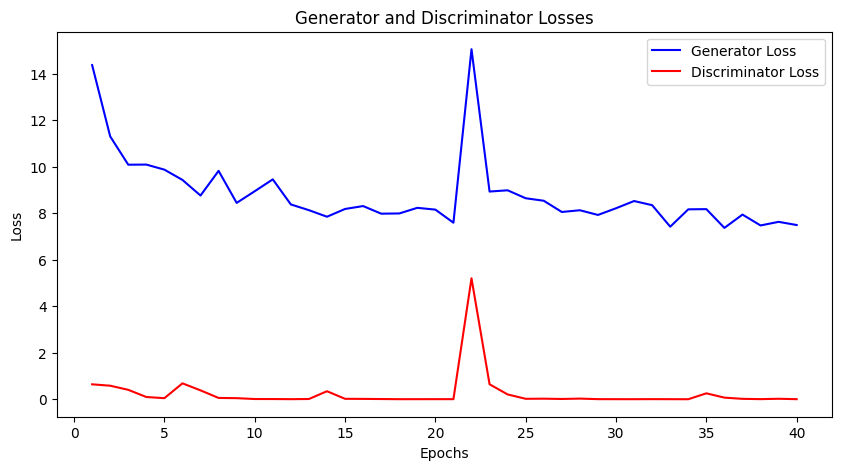

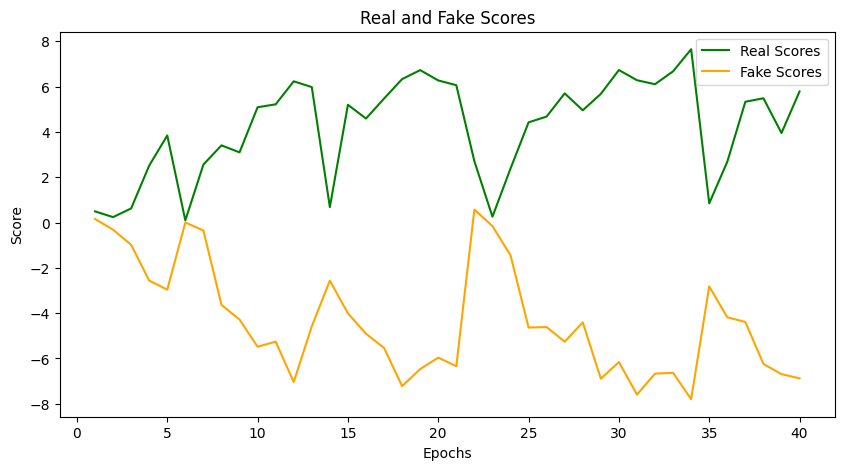

In [76]:
import matplotlib.pyplot as plt

def plot_losses(losses_g, losses_d, real_scores, fake_scores):
    epochs = range(1, len(losses_g) + 1)

    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, losses_g, label='Generator Loss', color='blue')
    plt.plot(epochs, losses_d, label='Discriminator Loss', color='red')
    plt.title('Generator and Discriminator Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot scores
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, real_scores, label='Real Scores', color='green')
    plt.plot(epochs, fake_scores, label='Fake Scores', color='orange')
    plt.title('Real and Fake Scores')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

# Call the function with your lists
plot_losses(losses_g, losses_d, real_scores, fake_scores)


In [79]:
test_dataset = DenoisingDataset(root_dir='./datasets/test/images/', noise_std=0.6, transform=data_transform)
test_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
history += fit(train_dl=train_loader, 
               epochs=30, 
               lr=LR, 
               generator_state_dict_file="/kaggle/working/models/best_generator.pth",
               discriminator_state_dict_file="/kaggle/working/models/best_discriminator.pth",
               start_idx=21
              )

In [ ]:
history

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
plot_losses(losses_g, losses_d, real_scores, fake_scores)


Saving latent tensor images: latent-images-4269.png
Saving fake images: generated-images-4269.png


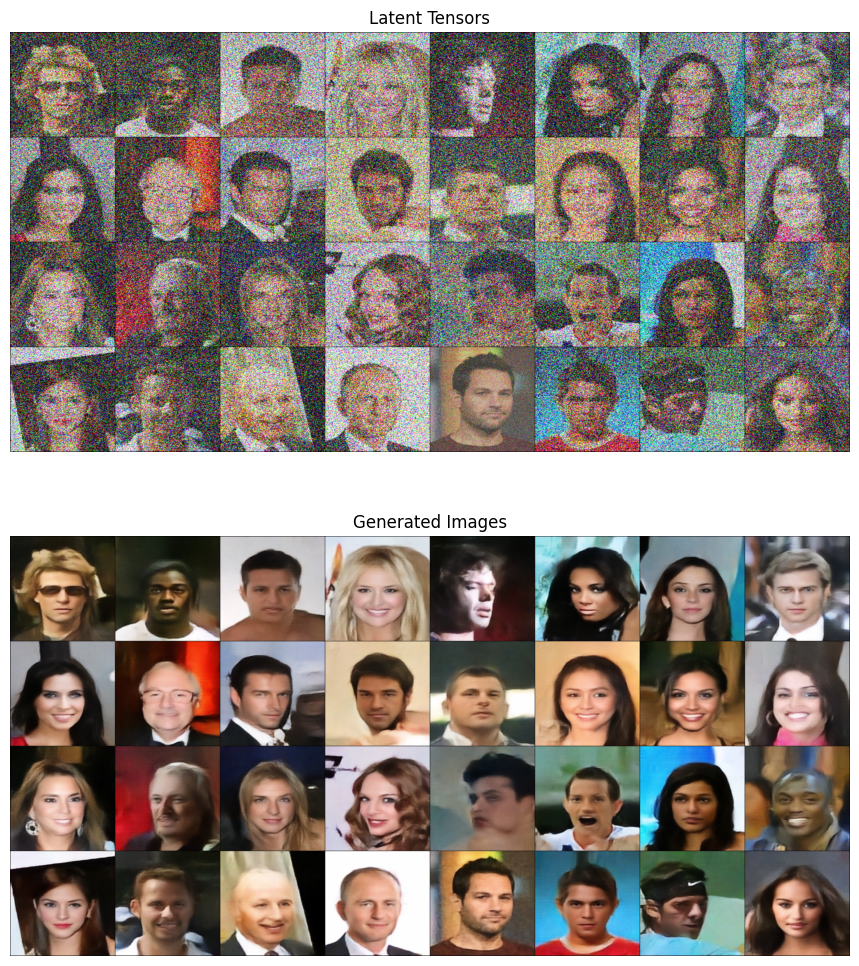

In [77]:
import os 
import torch 
import matplotlib.pyplot as plt 
from torchvision.utils import save_image, make_grid  

def save_batch_images(index, latent_tensors, generator, show=True, sample_dir="samples"):
    os.makedirs(sample_dir, exist_ok=True)

    # Save latent tensor images
    latent_fname = f"noisy-images-{index:0=4d}.png"
    save_image(denorm(latent_tensors), os.path.join(sample_dir, latent_fname), nrow=8)
    print("Saving latent tensor images:", latent_fname)

    # Generate fake images from latent vectors
    generator.eval()
    generated_images = generator(latent_tensors)
    
    # Save fake images
    fake_fname = f"generated-images-{index:0=4d}.png"
    save_image(denorm(generated_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print("Saving fake images:", fake_fname)
    
    # Show latent tensors and generated images if requested
    if show:
        num_images = min(len(latent_tensors), len(generated_images))
        latent_tensor_grid = make_grid(denorm(latent_tensors.cpu().detach()), nrow=8)
        generated_images_grid = make_grid(denorm(generated_images.cpu().detach()), nrow=8)
        
        fig, axes = plt.subplots(2, 1, figsize=(12, 12))
        
        axes[0].imshow(latent_tensor_grid.permute(1, 2, 0))
        axes[0].set_title("Latent Tensors")
        axes[0].axis('off')
        
        axes[1].imshow(generated_images_grid.permute(1, 2, 0))
        axes[1].set_title("Generated Images")
        axes[1].axis('off')
        
        plt.show()

# Assuming 'fixed_noisy' contains the latent tensors and 'generator' is your generator model
# Call the function to save and optionally show latent tensors and generated images
gen_sd = torch.load("./models/best_generator.pth")
generator = UnetGenerator().to(DEVICE)
generator.load_state_dict(gen_sd)
save_batch_images(4269, fixed_latent.to(DEVICE), generator)




Saving latent tensor images: latent-images-9999.png
Saving fake images: generated-images-9999.png


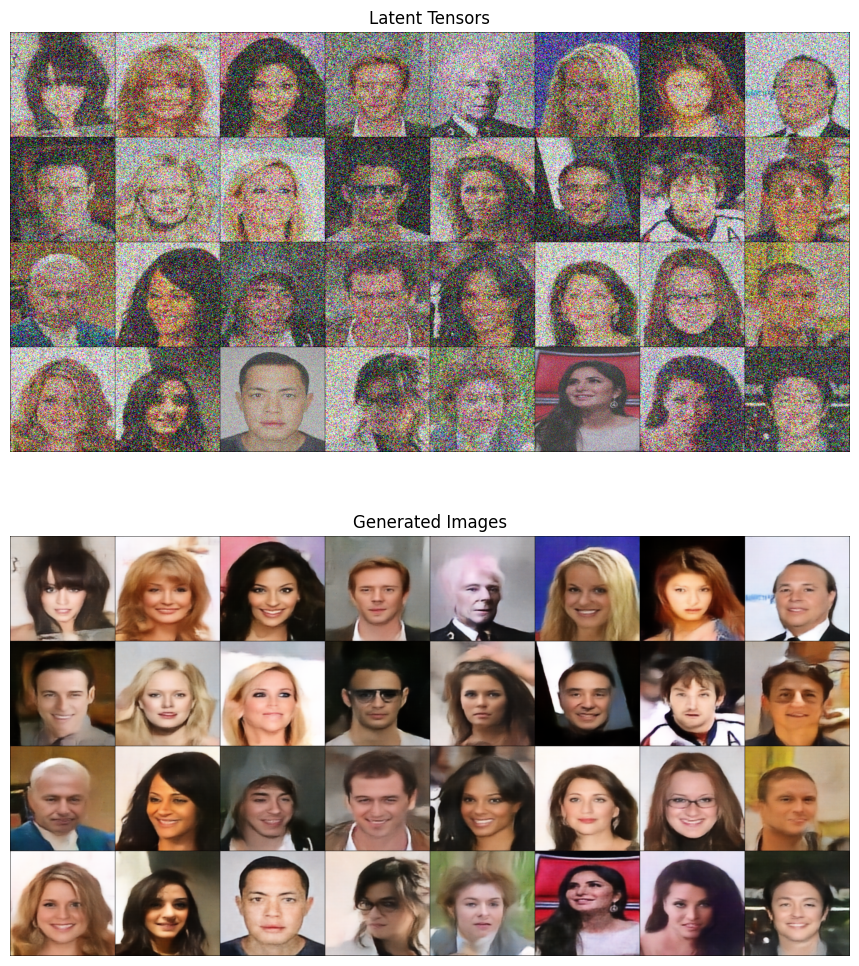

In [95]:

for noisy, clean in test_loader:
    save_batch_images(9999, noisy.to(DEVICE), generator)
    break

In [93]:
# import torch
# from skimage.metrics import peak_signal_noise_ratio as compare_psnr
# from skimage.metrics import structural_similarity as compare_ssim

# def evaluate_psnr_ssim(generator, test_loader, device):
#     generator.eval()
#     psnr_scores = []
#     ssim_scores = []

#     with torch.no_grad():
#         for noisy_images, clean_images in tqdm(test_loader, colour="CYAN"):
#             noisy_images = noisy_images.to(device)
#             clean_images = clean_images.to(device)

#             # Generate denoised images
#             denoised_images = generator(noisy_images)

#             # Convert images to numpy arrays
#             denoised_images_np = denoised_images.cpu().detach().numpy().transpose(0, 2, 3, 1)
#             clean_images_np = clean_images.cpu().detach().numpy().transpose(0, 2, 3, 1)

#             # Calculate PSNR and SSIM for each pair of images
#             for denoised_img, clean_img in zip(denoised_images_np, clean_images_np):
#                 psnr = compare_psnr(clean_img, denoised_img, data_range=1.0)
# #                 ssim = compare_ssim(clean_img, denoised_img, full=True)  # Specify win_size

#                 psnr_scores.append(psnr)
# #                 ssim_scores.append(ssim)

#     avg_psnr = sum(psnr_scores) / len(psnr_scores)
# #     avg_ssim = sum(ssim_scores) / len(ssim_scores)

#     return avg_psnr

# test_loader = create_test_dataloader()

# eval_data = evaluate_psnr_ssim(generator, test_loader, DEVICE)

In [96]:
import torch
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

def evaluate_psnr_ssim(generator, test_loader, device):
    generator.eval()
    psnr_scores = []
    ssim_scores = []

    with torch.no_grad():
        for noisy_images, clean_images in tqdm(test_loader, colour="CYAN"):
            noisy_images = noisy_images.to(device)
            clean_images = clean_images.to(device)

            # Generate denoised images
            denoised_images = generator(noisy_images)

#             print(f"""
#                 The image size is :
#                 noisy_image.shape    : {noisy_images.shape}
#                 noisy_image.dtype    : {noisy_images.dtype}
#                 clean_image.shape    : {clean_images.shape}
#                 clean_image.dtype    : {clean_images.dtype}
#                 denoised_image.shape : {denoised_images.shape}
#                 denoised_image.dtype : {denoised_images.dtype}
#             """)
            # Convert images to numpy arrays
            denoised_images_np = denoised_images.cpu().detach().numpy().transpose(0, 2, 3, 1)
            clean_images_np = clean_images.cpu().detach().numpy().transpose(0, 2, 3, 1)

            # Calculate PSNR and SSIM for each pair of images
            for denoised_img, clean_img in zip(denoised_images_np, clean_images_np):
                psnr = compare_psnr(clean_img, denoised_img, data_range=1.0)
                ssim = compare_ssim(clean_img, denoised_img, win_size=3, multichannel=True, gaussian_weights=True, data_range=1)

                psnr_scores.append(psnr)
                ssim_scores.append(ssim)

    avg_psnr = sum(psnr_scores) / len(psnr_scores)
    avg_ssim = sum(ssim_scores) / len(ssim_scores)

    return avg_psnr, avg_ssim


eval_data = evaluate_psnr_ssim(generator, test_loader, DEVICE)
eval_data

  0%|          | 0/64 [00:00<?, ?it/s]

(19.637912002546024, 0.7277005208875503)

In [97]:
print(f"avg_psnr : {eval_data[0]}, avg_ssim : {eval_data[1]}")

avg_psnr : 19.637912002546024, avg_ssim : 0.7277005208875503


In [99]:
!mkdir data

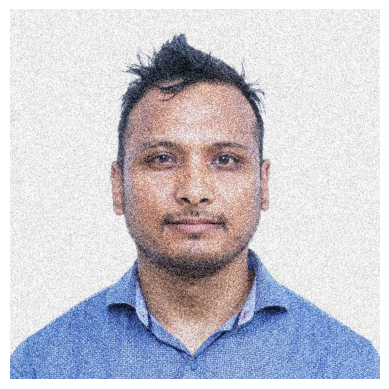

In [100]:
import requests
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

# Function to download and display the image
def download_and_display_image(image_url, image_path):
    # Download image if it does not exist
    if not image_path.is_file():
        with open(image_path, "wb") as f:
            request = requests.get(image_url)
            print(f"Downloading {image_path}")
            f.write(request.content)
    else:
        print(f"{image_path} already exists, skipping download...")
    
    # Open and display the image using matplotlib
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Path to save the image
image_path = Path("./data/pranaya_sir.jpg")

# Image URL
image_url = "https://files.saurabtharu.com.np/pranaya_sir.jpg"
# Download and display the image
download_and_display_image(image_url, image_path)


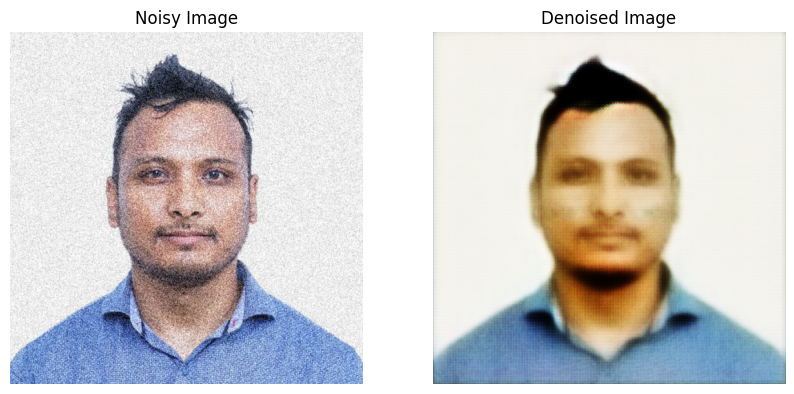

In [106]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt



def denorm(img_tensors):
    STATS = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    return img_tensors * STATS[1][0] + STATS[0][0] 


import torchvision

# Read the image
image_path = None
# try:
image_path= Path("/kaggle/working/data/pranaya_sir.jpg")

image = Image.open(str(image_path))

# Define transformations
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     Add any other transformations you want here
])

# Apply transformations
input_image = transform(image).unsqueeze(0)  


generator_state_dict = torch.load('/kaggle/working/models/generator_epoch_10.pth')
generator = UnetGenerator().to(DEVICE)
generator.load_state_dict(generator_state_dict)


# Send the input image to the generator for processing
denoised_image = generator(input_image.to(DEVICE))

# Plot the original and denoised images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Noisy Image')
plt.imshow(denorm(input_image.squeeze(0).permute(1,2,0)))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Denoised Image')
plt.imshow(denorm(denoised_image).squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
plt.axis('off')

plt.show()
